# Trabajo Práctico 7
1. El conjunto de datos clásico de caras Olivetti contiene 400 imágenes de caras en escala de grises de 64 × 64 píxeles. Cada imagen se aplana en un vector 1D de tamaño 4,096. Se fotografiaron 40 personas diferentes (10 veces cada una), y la tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen. Cargue el conjunto de datos utilizando la función sklearn.datasets.fetch_olivetti_faces(), luego divídalo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de prueba (note que el conjunto de datos ya está escalado entre 0 y 1). Dado que el conjunto de datos es bastante pequeño, probablemente desee utilizar un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto. A continuación, agrupe las imágenes utilizando K-Means y asegúrese de tener un buen número de clústeres (usando una de las técnicas discutidas en este capítulo). Visualice los clústeres: ¿ve caras similares en cada clúster?

1. Continuando con el conjunto de datos de caras Olivetti, entrene un clasificador para predecir qué persona está representada en cada imagen y evalúelo en el conjunto de validación. A continuación, utilice K-Means como herramienta de reducción de dimensionalidad y entrene un clasificador en el conjunto reducido. Busque el número de clústeres que permita al clasificador obtener el mejor rendimiento: ¿qué rendimiento puede alcanzar? ¿Qué sucede si agrega las características del conjunto reducido a las características originales (nuevamente, buscando el mejor número de clústeres)?

1. Entrene un modelo Gaussian Mixture en el conjunto de datos de caras Olivetti. Para acelerar el algoritmo, probablemente deberá reducir la dimensionalidad del conjunto de datos (por ejemplo, usando PCA, conservando el 99% de la varianza). Utilice el modelo para generar algunas caras nuevas (utilizando el método sample()), y visualícelas (si usó PCA, deberá utilizar su método inverse_transform()). Intente modificar algunas imágenes (por ejemplo, rotar, voltear, oscurecer) y vea si el modelo puede detectar las anomalías (es decir, compare la salida del método score_samples() para imágenes normales y anomalías).

1. Algunas técnicas de reducción de dimensionalidad también se pueden utilizar para la detección de anomalías. Por ejemplo, tome el conjunto de datos de caras Olivetti y redúzcalo con PCA, conservando el 99% de la varianza. Luego, calcule el error de reconstrucción para cada imagen. A continuación, tome algunas de las imágenes modificadas que construyó en el ejercicio anterior y observe su error de reconstrucción: observe cuánto mayor es el error de reconstrucción. Si traza una imagen reconstruida, verá por qué: intenta reconstruir una cara normal.


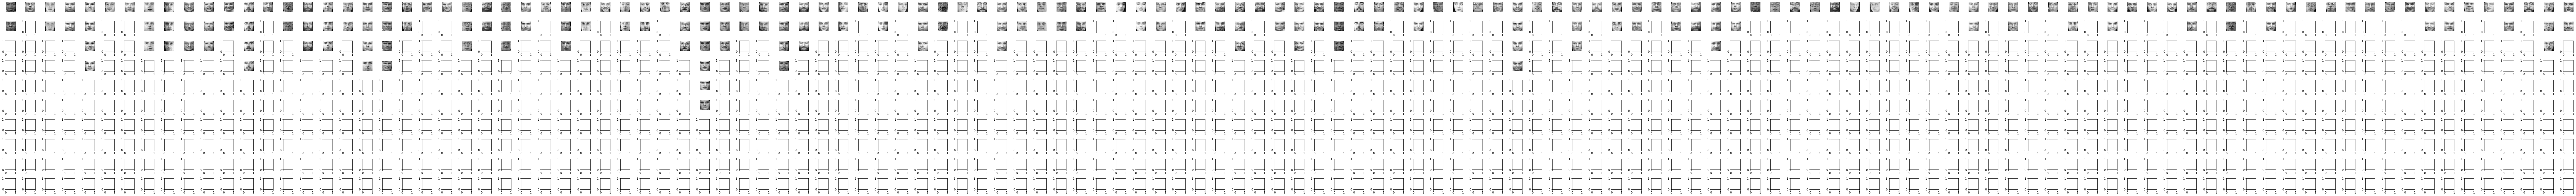

In [15]:
#1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Cargar el conjunto de datos de caras Olivetti
data = fetch_olivetti_faces()
X = data.data
y = data.target

# Dividir el conjunto de datos en entrenamiento, validación y prueba
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Aplicar muestreo estratificado para mantener el mismo número de imágenes por persona en cada conjunto
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

# Aplicar K-Means para agrupar las imágenes
n_clusters = 130  # Número de clústeres
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

kmeans.fit(X_train)

# Calcular las distancias entre las imágenes de cada clúster y el centroide
distances = cdist(X_train, kmeans.cluster_centers_, metric='euclidean')

# Visualizar los clústeres y las imágenes más similares
fig, axes = plt.subplots(10, n_clusters, figsize=(n_clusters, 10))

# Iterar sobre cada clúster
for cluster in range(n_clusters):
    # Obtener las imágenes del clúster actual
    cluster_images = X_train[kmeans.labels_ == cluster]
    # Calcular las distancias de las imágenes del clúster al centroide
    cluster_distances = distances[kmeans.labels_ == cluster, cluster]
    # Obtener los índices de las imágenes más similares
    most_similar_indices = np.argsort(cluster_distances)
    # Mostrar las imágenes más similares en la columna correspondiente
    num_images = min(10, len(most_similar_indices))  # Ajustar la cantidad de imágenes mostradas
    for i in range(num_images):
        axes[i, cluster].imshow(cluster_images[most_similar_indices[i]].reshape(64, 64), cmap='gray')
        axes[i, cluster].axis('off')

# Ajustar los espacios entre subgráficos
fig.tight_layout()
plt.show()


In [16]:
#2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Cargar el conjunto de datos de caras Olivetti
data = fetch_olivetti_faces()
X = data.data
y = data.target

# Dividir el conjunto de datos en entrenamiento, validación y prueba
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Entrenar un clasificador en el conjunto de entrenamiento 
classifier_original = make_pipeline(StandardScaler(), SVC())
classifier_original.fit(X_train, y_train)

# Evaluar el rendimiento en el conjunto de validación original
accuracy_original = accuracy_score(y_val, classifier_original.predict(X_val))
print("Rendimiento en conjunto de validación (original):", accuracy_original)

# Utilizar K-Means para reducción de dimensionalidad
n_clusters = 130  # Número de clústeres
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_train)

# Reducir dimensionalidad del conjunto de entrenamiento utilizando los clústeres
X_train_reduced = kmeans.transform(X_train)

# Entrenar un clasificador en el conjunto de entrenamiento reducido
classifier_reduced = make_pipeline(StandardScaler(), SVC())
classifier_reduced.fit(X_train_reduced, y_train)

# Evaluar el rendimiento en el conjunto de validación reducido
X_val_reduced = kmeans.transform(X_val)
accuracy_reduced = accuracy_score(y_val, classifier_reduced.predict(X_val_reduced))
print("Rendimiento en conjunto de validación (reducido):", accuracy_reduced)

# Combinar características originales con características del conjunto reducido
X_train_combined = np.hstack((X_train, X_train_reduced))
X_val_combined = np.hstack((X_val, X_val_reduced))

# Entrenar un clasificador en el conjunto de entrenamiento combinado
classifier_combined = make_pipeline(StandardScaler(), SVC())
classifier_combined.fit(X_train_combined, y_train)

# Evaluar el rendimiento en el conjunto de validación combinado
accuracy_combined = accuracy_score(y_val, classifier_combined.predict(X_val_combined))
print("Rendimiento en conjunto de validación (combinado):", accuracy_combined)


Rendimiento en conjunto de validación (original): 0.775
Rendimiento en conjunto de validación (reducido): 0.5125
Rendimiento en conjunto de validación (combinado): 0.775


En este código, entrenamos un clasificador en el conjunto de entrenamiento original y evaluamos su rendimiento en el conjunto de validación. Luego utilizamos K-Means para reducir la dimensionalidad del conjunto de entrenamiento y entrenamos otro clasificador en el conjunto reducido. Evaluamos el rendimiento de este clasificador en el conjunto de validación reducido. Además, combinamos las características originales con las características del conjunto reducido y entrenamos un tercer clasificador en el conjunto combinado, evaluando su rendimiento en el conjunto de validación combinado.

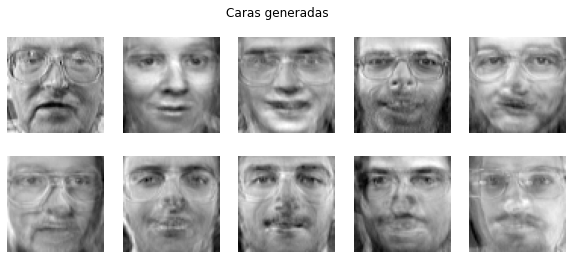

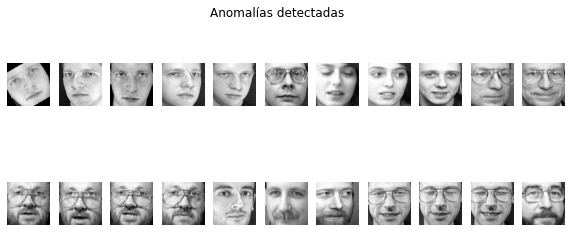

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.ndimage import rotate

# Cargar el conjunto de datos de caras Olivetti
data = fetch_olivetti_faces()
X = data.data
y = data.target

# Reducción de dimensionalidad utilizando PCA
pca = PCA(n_components=0.99, random_state=42)
X_reduced = pca.fit_transform(X)

# Entrenar modelo Gaussian Mixture con el conjunto reducido
gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(X_reduced)

# Generar nuevas caras
n_samples = 10
new_faces_reduced = gmm.sample(n_samples)[0]
new_faces = pca.inverse_transform(new_faces_reduced)

# Visualizar las nuevas caras
fig, axes = plt.subplots(2, n_samples//2, figsize=(10, 4))
fig.suptitle('Caras generadas')

for i, ax in enumerate(axes.flatten()):
    ax.imshow(new_faces[i].reshape(64, 64), cmap='gray')
    ax.axis('off')

plt.show()

# Modificar algunas imágenes
X_modified = np.copy(X)
X_modified[0] = rotate(X[0].reshape(64, 64), angle=30, reshape=False).flatten()  # Rotar la primera imagen
X_modified[1] = np.fliplr(X[1].reshape(64, 64)).flatten()  # Voltear horizontalmente la segunda imagen
X_modified[2] = np.clip(X[2] - 0.2, 0, 1).flatten()  # Oscurecer la tercera imagen

# Calcular las puntuaciones de las imágenes originales
score_original = gmm.score_samples(pca.transform(X))

# Calcular las puntuaciones de las imágenes modificadas
score_modified = gmm.score_samples(pca.transform(X_modified))

# Definir un umbral para detectar anomalías
threshold = np.percentile(score_original, 5)

# Detectar las anomalías
anomalies = X_modified[score_modified < threshold]

# Verificar si hay suficientes anomalías para crear 2 filas de subtramas
if len(anomalies) >= 2:
    fig, axes = plt.subplots(2, len(anomalies)//2, figsize=(10, 4))
else:
    fig, axes = plt.subplots(1, len(anomalies), figsize=(10, 4))

fig.suptitle('Anomalías detectadas')

for i, ax in enumerate(axes.flatten()):
    ax.imshow(anomalies[i].reshape(64, 64), cmap='gray')
    ax.axis('off')

plt.show()




    Carga el conjunto de datos de caras Olivetti utilizando la función fetch_olivetti_faces de scikit-learn.
    Utiliza PCA (Análisis de Componentes Principales) para reducir la dimensionalidad del conjunto de datos original, conservando el 99% de la varianza. Esto se hace utilizando la clase PCA de scikit-learn.
    Entrena un modelo Gaussian Mixture con el conjunto de datos reducido. El modelo Gaussian Mixture es un modelo de mezcla de distribuciones gaussianas utilizado para modelar distribuciones de datos.
    Genera nuevas caras utilizando el modelo Gaussian Mixture y la función sample para generar muestras a partir del modelo.
    Visualiza las nuevas caras generadas.
    Modifica algunas imágenes del conjunto de datos original, rotando, volteando horizontalmente y oscureciendo las imágenes.
    Calcula las puntuaciones (log-probabilidades) de las imágenes originales y las imágenes modificadas utilizando el modelo Gaussian Mixture.
    Define un umbral utilizando el percentil 5 de las puntuaciones de las imágenes originales.
    Detecta las anomalías en las imágenes modificadas que tienen puntuaciones por debajo del umbral definido.
    Visualiza las anomalías detectadas.

En resumen, el código utiliza PCA para reducir la dimensionalidad del conjunto de datos de caras Olivetti, entrena un modelo Gaussian Mixture en el conjunto de datos reducido y luego utiliza el modelo para generar nuevas caras y detectar anomalías en las imágenes modificadas.

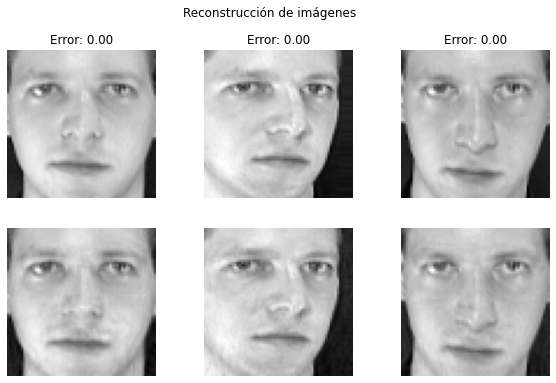

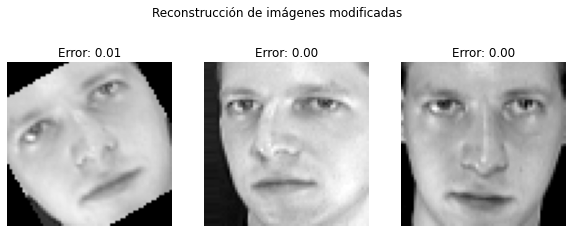

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

# Cargar el conjunto de datos de caras Olivetti
data = fetch_olivetti_faces()
X = data.data
y = data.target

# Reducción de dimensionalidad utilizando PCA
pca = PCA(n_components=0.99, random_state=42)
X_reduced = pca.fit_transform(X)

# Reconstrucción de las imágenes originales
X_reconstructed = pca.inverse_transform(X_reduced)

# Calcular el error de reconstrucción para cada imagen
reconstruction_errors = np.mean((X - X_reconstructed) ** 2, axis=1)

# Obtener las imágenes modificadas del ejercicio anterior
modified_images = X_modified[:3]  # Modificar solo las primeras 3 imágenes

# Reconstrucción de las imágenes modificadas
modified_reconstructed = pca.inverse_transform(pca.transform(modified_images))

# Calcular el error de reconstrucción para las imágenes modificadas
modified_errors = np.mean((modified_images - modified_reconstructed) ** 2, axis=1)

# Visualizar las imágenes originales y sus reconstrucciones
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle('Reconstrucción de imágenes')

for i, ax in enumerate(axes[0]):
    ax.imshow(X[i].reshape(64, 64), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Error: {reconstruction_errors[i]:.2f}')

for i, ax in enumerate(axes[1]):
    ax.imshow(X_reconstructed[i].reshape(64, 64), cmap='gray')
    ax.axis('off')

# Visualizar las imágenes modificadas y sus reconstrucciones
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle('Reconstrucción de imágenes modificadas')

for i, ax in enumerate(axes):
    ax.imshow(modified_images[i].reshape(64, 64), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Error: {modified_errors[i]:.2f}')

plt.show()


El código realiza las siguientes tareas:

    Carga el conjunto de datos de caras Olivetti utilizando la función fetch_olivetti_faces de scikit-learn.
    Utiliza PCA para reducir la dimensionalidad del conjunto de datos original. Se especifica que se desea conservar el 99% de la varianza.
    Reconstruye las imágenes originales a partir de los datos reducidos utilizando el método inverse_transform de PCA.
    Calcula el error de reconstrucción para cada imagen comparando las imágenes originales con sus reconstrucciones. El error se calcula como el promedio de la diferencia al cuadrado entre los píxeles de las imágenes.
    Selecciona las imágenes modificadas del ejercicio anterior (las primeras 3 imágenes) y realiza su reconstrucción utilizando PCA.
    Calcula el error de reconstrucción para las imágenes modificadas.
    Visualiza las imágenes originales junto con sus reconstrucciones y muestra el valor del error de reconstrucción en cada caso.
    Visualiza las imágenes modificadas junto con sus reconstrucciones y muestra el valor del error de reconstrucción en cada caso.

De esta manera, se puede observar cuánto difiere la reconstrucción de las imágenes modificadas en comparación con las originales, lo que ayuda a identificar anomalías o diferencias significativas.

## resumen de todo el practico
    Conjunto de datos de caras Olivetti: Es un conjunto de datos que contiene imágenes de caras en escala de grises de 64x64 píxeles. Hay 400 imágenes en total, pertenecientes a 40 personas diferentes (10 imágenes por persona).

    Reducción de dimensionalidad: Se utilizan técnicas como PCA (Análisis de Componentes Principales) para reducir la dimensionalidad del conjunto de datos. El objetivo es encontrar representaciones más compactas y significativas de las imágenes, conservando la mayor cantidad posible de información.

    K-Means: Es un algoritmo de agrupamiento que se utiliza para agrupar las imágenes en clústeres basados en características similares. Se busca encontrar el número óptimo de clústeres que permita una buena agrupación de las imágenes.

    Gaussian Mixture Models (GMM): Es un modelo probabilístico utilizado para el modelado de distribuciones de datos. En el contexto de las imágenes de caras Olivetti, se puede utilizar un modelo GMM para generar nuevas caras basadas en las características aprendidas del conjunto de datos original.

    Detección de anomalías: Utilizando técnicas de reducción de dimensionalidad y modelos GMM, es posible detectar anomalías en las imágenes modificadas. Se calcula el error de reconstrucción y se establece un umbral para identificar las anomalías.

    Evaluación del rendimiento: Se evalúa el rendimiento de los algoritmos y modelos utilizando conjuntos de entrenamiento, validación y prueba. Se pueden utilizar métricas como la precisión, el error de reconstrucción, entre otras, para evaluar la calidad de los resultados obtenidos.

En resumen, las tareas principales son la reducción de dimensionalidad, el agrupamiento de imágenes mediante K-Means, la generación de nuevas caras utilizando modelos GMM, la detección de anomalías y la evaluación del rendimiento de los algoritmos y modelos utilizados. Es importante comprender los conceptos de reducción de dimensionalidad, agrupamiento, modelos probabilísticos y evaluación de rendimiento para aplicar estas técnicas de manera efectiva en el procesamiento de imágenes.


### Preguntas teóricas

1. ¿Cómo definirías el agrupamiento (clustering)? ¿Puedes nombrar algunos algoritmos de clustering?
1. ¿Cuáles son algunas de las principales aplicaciones de los algoritmos de clustering?
1.  Describe dos técnicas para seleccionar el número adecuado de clusters al utilizar K-Means.
1. ¿Qué es la propagación de etiquetas (label propagation)? ¿Por qué la implementarías y cómo?
1. ¿Puedes nombrar dos algoritmos de clustering que puedan escalar a conjuntos de datos grandes? ¿Y dos que busquen regiones de alta densidad?
1. ¿Puedes pensar en un caso de uso donde el aprendizaje activo sería útil? ¿Cómo lo implementarías?
1. ¿Cuál es la diferencia entre la detección de anomalías y la detección de novedades?
1. ¿Qué es un modelo de Gaussian Mixture? ¿Para qué tareas se puede usar?
1. ¿Puedes nombrar dos técnicas para encontrar el número adecuado de clusters al usar un modelo de Gaussian Mixture?




1. 

    El agrupamiento (clustering) es una técnica de aprendizaje no supervisado que consiste en dividir un conjunto de datos en grupos o clústeres basados en la similitud de sus características. El objetivo es que los elementos dentro de un mismo clúster sean similares entre sí y diferentes de los elementos en otros clústeres. Algunos algoritmos de clustering populares son K-Means, DBSCAN, Agglomerative Hierarchical Clustering y Gaussian Mixture Models (GMM).

    Algunas de las principales aplicaciones de los algoritmos de clustering son:

    Segmentación de clientes: Agrupar clientes con características similares para estrategias de marketing personalizadas.
    Análisis de redes sociales: Identificar comunidades o grupos de usuarios con intereses similares.
    Agrupamiento de documentos: Organizar documentos en temas o categorías similares.
    Compresión de datos: Agrupar datos similares para reducir su tamaño y complejidad.
    Reconocimiento de patrones: Identificar grupos o estructuras en conjuntos de datos para el análisis exploratorio.

    Dos técnicas para seleccionar el número adecuado de clústeres en K-Means son:

    Método del codo (Elbow Method): Se ejecuta K-Means con diferentes valores de k y se calcula la suma de las distancias cuadradas intra-cluster. Se selecciona el valor de k en el punto de "codo" en el gráfico de la suma de las distancias cuadradas versus el número de clústeres.
    Coeficiente de silueta (Silhouette Coefficient): Se calcula el coeficiente de silueta para diferentes valores de k y se selecciona el valor de k que maximiza el coeficiente. El coeficiente de silueta mide la coherencia y separación de los clústeres.

    La propagación de etiquetas (label propagation) es un algoritmo de aprendizaje semi-supervisado que utiliza información parcialmente etiquetada para asignar etiquetas a muestras no etiquetadas. La implementación implica construir un grafo de conectividad entre las muestras y propagar las etiquetas conocidas a través de las conexiones del grafo. Se implementa para aprovechar la información parcialmente etiquetada y mejorar el rendimiento de un modelo de clasificación.

    Dos algoritmos de clustering que pueden escalar a conjuntos de datos grandes son:

    Mini-Batch K-Means: Es una variante de K-Means que utiliza mini lotes aleatorios del conjunto de datos para realizar actualizaciones más rápidas de los centroides. Esto lo hace adecuado para conjuntos de datos grandes donde no se puede ajustar el modelo completo en memoria.
    DBSCAN (Density-Based Spatial Clustering of Applications with Noise): Utiliza la densidad de las muestras en el espacio de características para identificar regiones de alta densidad y agruparlas. Puede escalar a conjuntos de datos grandes al evitar la necesidad de calcular distancias entre todas las muestras.

    Un caso de uso donde el aprendizaje activo sería útil es en la clasificación de documentos. En este caso, se pueden utilizar algoritmos de aprendizaje activo para seleccionar estratégicamente muestras de documentos para ser etiquetadas por expertos humanos. Se pueden utilizar medidas de incertidumbre o diversidad para seleccionar las muestras más informativas o representativas